In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [16]:
# Read data
fp = "/Users/daryanfadavi/Downloads/MU.txt"
data = pd.read_csv(fp, delimiter = "\t", header = None, names = ["id", "event", "device", "channel", "code", "size", "data"])

In [17]:
data.head()

,id,event,device,channel,code,size,data
0,978111,132669,MU,TP9,6,459,"475,474,477,486,486,476,479,483,489,483,482,48..."
1,978112,132669,MU,FP1,6,459,"468,487,493,493,498,493,491,490,492,487,483,48..."
2,978113,132669,MU,FP2,6,459,"482,475,490,500,485,470,470,482,490,484,478,48..."
3,978114,132669,MU,TP10,6,459,"470,470,478,489,487,475,469,478,488,483,474,48..."
4,978115,132670,MU,TP9,7,493,"506,499,495,491,492,507,496,500,498,496,499,50..."


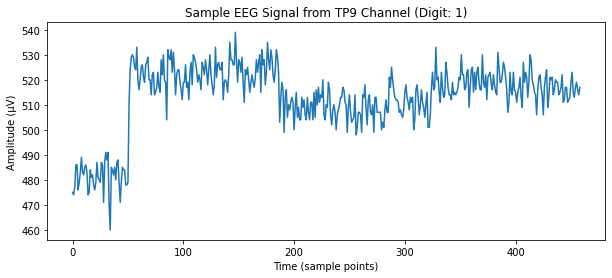

In [18]:
# Convert data from strings to float values
data["data"] = data["data"].apply(lambda x: [float(i) for i in x.split(",")])

#Filter for specific device 
muse_data = data[(data["device"] == "MU") & (data["channel"].isin(["TP9", "FP1", "FP2", "TP10"]))]

# Extract a sample trial and plot it
sample = muse_data[(muse_data["channel"] == "TP9") & (muse_data["code"] == 1)].iloc[0]["data"]

plt.figure(figsize=(10, 4))
plt.plot(muse_data["data"].iloc[0])
plt.title("Sample EEG Signal from TP9 Channel (Digit: 1)")
plt.xlabel("Time (sample points)")
plt.ylabel("Amplitude (µV)")
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

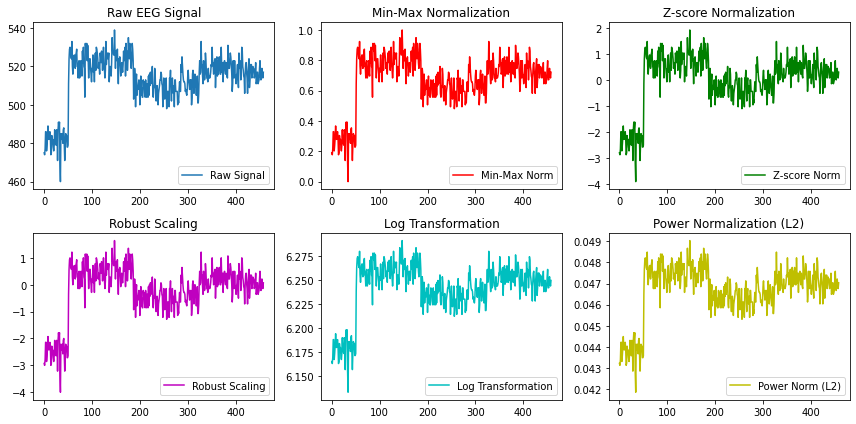

In [21]:
# NORMALIZING USING DIFFERENT METHODS

sample = np.array(muse_data[muse_data["channel"] == "TP9"]["data"].iloc[0])

min_max_scaler = MinMaxScaler()
z_score_scaler = StandardScaler()
robust_scaler = RobustScaler()

min_max_norm = min_max_scaler.fit_transform(sample.reshape(-1, 1)).flatten()
z_score_norm = z_score_scaler.fit_transform(sample.reshape(-1, 1)).flatten()
robust_norm = robust_scaler.fit_transform(sample.reshape(-1, 1)).flatten()
log_norm = np.log(sample + 1)  # Adding 1 to avoid log(0)
power_norm = normalize(sample.reshape(1, -1), norm="l2").flatten()

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(sample, label="Raw Signal")
plt.title("Raw EEG Signal")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(min_max_norm, label="Min-Max Norm", color="r")
plt.title("Min-Max Normalization")
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(z_score_norm, label="Z-score Norm", color="g")
plt.title("Z-score Normalization")
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(robust_norm, label="Robust Scaling", color="m")
plt.title("Robust Scaling")
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(log_norm, label="Log Transformation", color="c")
plt.title("Log Transformation")
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(power_norm, label="Power Norm (L2)", color="y")
plt.title("Power Normalization (L2)")
plt.legend()

plt.tight_layout()
plt.show()

/Users/daryanfadavi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


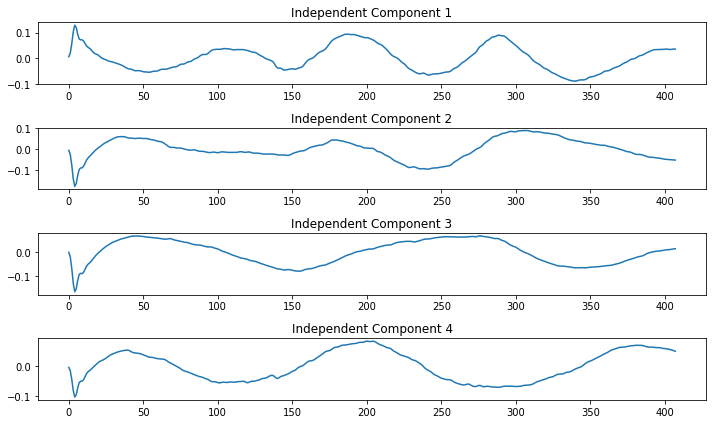

In [22]:
# APPLYING ICA

from sklearn.decomposition import FastICA
from scipy.signal import butter, lfilter

# Function for bandpass filtering
def bandpass_filter(data, lowcut=1.0, highcut=50.0, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

# Find the minimum sequence length to ensure uniformity
min_length = min(muse_data["data"].apply(len))

# Truncate all signals to min_length
muse_data["data"] = muse_data["data"].apply(lambda x: x[:min_length])

# Convert to a NumPy matrix
eeg_matrix = np.array(muse_data["data"].tolist()).T

# Apply bandpass filtering
eeg_matrix = np.apply_along_axis(bandpass_filter, 0, eeg_matrix)

# Apply ICA
ica = FastICA(n_components=4, random_state=42)
independent_components = ica.fit_transform(eeg_matrix)  # Decomposed sources

# Plot results
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(independent_components[:, i])
    plt.title(f"Independent Component {i+1}")
plt.tight_layout()
plt.show()